# Homework 3: film dialogue

In our lab for Feb 15 we looked at two different ways to compare collections of texts: by examining specific words that are overrepresented in one collection relative to another, or by assessing the strength of a model that attempts to describe the boundary between the two.

We'll pursue both of those strategies a little further in this homework.


## Familiar preparation

To start with we'll import useful modules.

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path

#### read in the dialogue dataset

It has one line for each character; the field ```lines``` contains all dialogue attributed to that character in the [Cornell Movie Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). Separate lines are delimited by slashes, but we'll ignore that here.

We call the dataset ```chars``` because the it has one line per character.

Notice that the path below has changed because the ```homeworks/``` directory is only one level down from the parent is417 directory. ```labs/Feb15Dialog/``` was two levels down.

In [2]:
dialogpath = Path('../data/movie_dialogue.tsv')

chars = pd.read_csv(dialogpath, sep = '\t')

# let's also randomize the row order
chars = chars.sample(frac = 1.0)

In [3]:
chars.head()

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
1400,m353,u5327,TITA,five easy pieces,f,607,1970,['drama'],False,False,True,False,"Bye, Robert. / But what about me? / You were g..."
255,m145,u2265,ROACH,next friday,m,279,2000,['comedy'],True,False,False,False,"Fuck, what's his name? / Dude, dogs hate me. ..."
2507,m564,u8292,DEBORAH,the lost son,f,1309,1999,"['crime', 'drama', 'romance', 'thriller']",False,True,True,True,I... We have to bury Leon tommorrow... / You w...
2954,m96,u1430,LINDA,invaders from mars,f,393,1953,"['horror', 'sci-fi']",False,False,False,False,"Why, yes. Why? / He was upset with moving, I ..."
2477,m557,u8208,NOVAK,the cell,m,722,2000,"['drama', 'fantasy', 'horror', 'sci-fi', 'thri...",False,True,True,False,No problem. / I got it. / I don't know. I thi...


## A better way to validate models

In our lab, we spent a lot of energy selecting test sets and training sets. We learned that if you want to produce a truly general model of a category like "comedy," it's important to make sure your algorithm can't "cheat" by just memorizing (say) the names of characters who appear in a limited set of comedies.

Defining train and test sets so they contain non-overlapping groups of movies produced a more general model of comedy, and a more realistic estimate of accuracy.

But each of us got a slightly different measure of model accuracy, because our measure of accuracy depended entirely on a small subset of the data (1/5th of the movies) that we randomly chose as the test set.

To get a more stable measure of accuracy, it's better to *cross-validate* your model, by repeatedly holding out a different 1/5th (or 1/10th) of the data as the test set, and training on the remainder. If we hold out a different test set each time we can eventually test on all the data, without ever testing on data that was included in our training set.

We could do this ourselves by writing a loop, but scikit-learn also comes with a ```cross_validate()``` function that does it for us automatically.

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict

First we need to create a matrix of ```wordcounts``` that we'll use to make predictions, and define a useful function

In [5]:
if 'cid' in chars.columns:         
    character_ids = chars['cid']
    chars = chars.set_index('cid')   # If we haven't made this the index yet, let's do it.
else:
    character_ids = chars.index.tolist()

vectorizer = CountVectorizer(max_features = 8000)
sparse_counts = vectorizer.fit_transform(chars['lines']) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
wordcounts = pd.DataFrame(sparse_counts.toarray(), index = character_ids, 
                            columns = vectorizer.get_feature_names())
wordcounts.head()

# We'll also define a useful function

def gendertonumber(astring):
    if astring.lower() == 'f':  # note that we lowercase before checking:
        return 1                    # this version of the function is slightly
    else:                           # better than the one in the lab notebook
        return 0

Having done that, we can proceed to train models.

In the lines below we cross-validate a model of romance, while making sure that the data is grouped by movie-id. If you're curious about GroupKFold (or any other aspect of scikit-learn), you can always [inspect the documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) Basically, what's happening here is that we define an object that splits the data up into five parts, and then instruct it to use movie-id to do the splitting.

What happens if you change the number of splits (```n_splits```) to 10, or to 2? If you see slight changes in accuracy, reflect on why they're happening.

In [6]:
all_y = chars['romance'].astype(int)
bayes = MultinomialNB(alpha = 1)
grouper = GroupKFold(n_splits = 5)
cv_results = cross_validate(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper)
np.mean(cv_results['test_score'])

0.6850795759733364

The ```cross_validate()``` function produces a different test_score for each of the five separate test sets. Above, we take the mean score, but we can also inspect them individually.

In [7]:
cv_results

{'fit_time': array([0.58093619, 0.55154705, 0.52368212, 0.52169085, 0.55365086]),
 'score_time': array([0.08528686, 0.06697512, 0.06687689, 0.06704617, 0.06641507]),
 'test_score': array([0.66666667, 0.67676768, 0.6986532 , 0.6969697 , 0.68634064])}

Notice that if we take out the ```groups``` and ```cv``` parameters it no longer divides the test and training sets by movie-id. In that case, we get an unrealistically high accuracy for genre, because genre becomes easy to predict if you can memorize the vocabulary of specific movies.

In [8]:
all_y = chars['romance'].astype(int)
bayes = MultinomialNB(alpha = 1)
cv_results = cross_validate(bayes, wordcounts, all_y)
np.mean(cv_results['test_score'])

0.8201509189704804

We can also use this same function to model gender. We just have to change the way the response variable *y* is generated.

In [9]:
all_y = chars['gender'].map(gendertonumber)
bayes = MultinomialNB(alpha = 1)
grouper = GroupKFold(n_splits = 5)
cv_results = cross_validate(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper)
score = np.mean(cv_results['test_score'])
print(score)

0.7322301145235378


## Assignment 1. Changing the smoothing parameter of the model

Write a little loop that tests the gender model above while varying the ```alpha``` parameter of the model.

Remember, this is the Laplacian smoothing--a number that gets added to the count of each word to acknowledge that it probably *sometimes* occurs in dialogue spoken by women (or by men), even if not in this sample.

Try each of the settings in this list: [0.001, 1, 2, 4, 8, 16, 32, 64]. In each case print ```alpha,``` and the resulting accuracy. Then do the same thing--in a separate cell--for a model of genre (say, romance).

In [10]:
for a in [0.001, 1, 2, 4, 8, 16, 32, 64]:
    all_y = chars['gender'].map(gendertonumber)
    bayes = MultinomialNB(alpha = a)
    grouper = GroupKFold(n_splits = 5)
    cv_results = cross_validate(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper)
    score = np.mean(cv_results['test_score'])
    print(a, score)

0.001 0.7409917045667467
1 0.7322301145235378
2 0.7278518745635104
4 0.7315589850159834
8 0.7551410677886226
16 0.6972115761323181
32 0.6803720169656089
64 0.6803714491741473


In [11]:
for a in [0.001, 1, 2, 4, 8, 16, 32, 64]:
    all_y = chars['romance'].astype(int)
    bayes = MultinomialNB(alpha = a)
    grouper = GroupKFold(n_splits = 5)
    cv_results = cross_validate(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper)
    score = np.mean(cv_results['test_score'])
    print(a, score)

0.001 0.7123602523265256
1 0.6850795759733364
2 0.6810386041414709
4 0.6972058982177026
8 0.7342542910839707
16 0.760516917346597
32 0.7621981478642523
64 0.7625348482009527


Why might alphas higher than one improve the model? Why is the ideal alpha not the same for every category? (Your answer may be a little speculative; that's okay; speculate.)

    Some datasets benefit from more smoothing than others. A naive "overfit" model can stray further from the truth, for instance, if the dataset includes a lot of variables, or if some variables have dramatically different frequencies in different subsets of a genre. In a situation like that you might need a lot of smoothing. Also, if the counts of features were simply higher across the board (for instance if the texts were longer), you might need more smoothing.
    
    More generally, this is an example of what's called "bias-variance tradeoff"; optimizing machine learning is a matter of finding a good balance between error within a sample and error *across* samples. And the optimal balance can be different in each dataset. We'll discuss this at more length in class.

## Assignment 2.

In the lab on Feb 15 we practiced ways to identify words that are overrepresented in one corpus relative to another.

If you review [Ben Schmidt's blog post about comparing corpuses,](http://sappingattention.blogspot.com/2011/10/comparing-corpuses-by-word-use.html), you'll realize that the methods we used in that lab were fairly crude. We were just asking how much larger a word's frequency is in one corpus than in the other, or how many *times* larger its frequency is. As Schmidt's post shows, there may be better ways to make that comparison, and in future weeks we'll explore them.

But for right now, let's just practice the simple ratio test. Create a list of 25 words that are many times more common in romances than in other movies, and a list of 25 words that are many times more common in other movies than in romances. Compare these lists to the similar test we performed on gender categories in the lab. The evidence you get from this comparison will not be decisive, but what hypotheses come to mind as deserving further investigation?

In [16]:
romance_counts = wordcounts.loc[chars['romance'] == True, : ].sum(axis = 'rows')
romance_counts[1000:1005]

bye        101
cab         41
cabin       15
cabinet      9
cable        8
dtype: int64

In [17]:
other_counts = wordcounts.loc[chars['romance'] == False, : ].sum(axis = 'rows')
other_counts[1000:1005]

bye        148
cab         74
cabin       46
cabinet     12
cable       38
dtype: int64

In [18]:
romance_freqs = (romance_counts + 100) / sum(romance_counts)
other_freqs = (other_counts + 100) / sum(other_counts)
ratios = other_freqs / romance_freqs
ratios = ratios.sort_values()
ratios[0:25]

hildy         0.197714
vada          0.221679
leon          0.236344
wyatt         0.239066
sailor        0.241781
baxter        0.243076
baron         0.243143
rick          0.244521
jeanne        0.244655
lula          0.247143
ninotchka     0.250528
alvy          0.252256
homer         0.253800
casablanca    0.254008
lombard       0.254008
marylin       0.254008
barry         0.256288
romeo         0.256766
preysing      0.257585
gallagher     0.257585
glenn         0.260917
wynant        0.261265
lawson        0.261265
yuh           0.263145
sieu          0.263145
dtype: float64

In [19]:
ratios[-25: ]

paul       1.112681
he         1.120457
harry      1.123439
the        1.123475
them       1.126300
need       1.133890
sir        1.136751
goddamn    1.143585
man        1.149095
jake       1.185098
dr         1.192372
captain    1.193568
we         1.194898
our        1.223458
ain        1.224317
dead       1.230806
killed     1.258457
they       1.279527
fuck       1.419654
kill       1.433346
us         1.436684
hell       1.457556
shit       1.527525
fucking    1.537658
fuckin     1.695847
dtype: float64

In [20]:
chars['gender'] = chars.gender.str.lower()
chars.groupby(['gender', 'romance'], as_index = False).count()

,gender,romance,mid,cname,mname,wordcount,year,genres,comedy,thriller,drama,lines
0,f,False,691,691,691,691,691,691,691,691,691,691
1,f,True,258,258,258,258,258,258,258,258,258,258
2,m,False,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573
3,m,True,447,447,447,447,447,447,447,447,447,447


## Assignment 3: do gender stereotypes weaken over time?

It probably doesn't make sense to try to answer this question with a single big model of all movies, because the gender norms involved in shaping dialogue could have *changed* over time.

Instead, let's find the median release date for characters, and divide our dataset into two roughly evenly-sized groups (early and late). Then we can cross-validate models to predict gender in each half of the dataset, and see if the accuracy of the later model is lower.

In the lab notebook, I proposed running this test many times, in order to measure uncertainty, and draw inferences about significance. But the technique of "sampling with replacement" may require more explanation. I'll demonstrate a way to do that in the homework solution, but for right now just cross-validate a single model for each half of the timeline -- using the methods from assignment 1 -- and see what result you get.

You may want to try different values of "alpha," as we did in Assignment 1, and use the value that performs best for each model.

In [22]:
np.median(chars['year'])

1995.0

#### A simple solution

This is what I hoped you would be able to do: split the data into two parts, and run a model on each part. We could use the alpha setting (8) that we identified as optimal for gender earlier. If you did that, it's reasonable.

But ideally we would check the optimal setting on a dataset closer in size to the one we'll be using: roughly half of the chars dataset, or 1484 characters. The optimal level of smoothing can be highly dependent on the size of a dataset.

In [73]:
for alpha in range(1, 10):
    
    # to get a good measure of accuracy at different alpha settings,
    # we'll try four different random samples at each setting
    
    fourscores = []
    
    for j in range(0, 4):
    
        chars = chars.sample(frac = 1)
        firsthalfchars = chars.iloc[0: 1484 : ]
        firsthalfwordcounts = wordcounts.loc[firsthalfchars.index.tolist(), : ]

        # model the first half

        all_y = firsthalfchars['gender'].map(gendertonumber)
        bayes = MultinomialNB(alpha = alpha)
        grouper = GroupKFold(n_splits = 5)
        cv_results = cross_validate(bayes, firsthalfwordcounts, all_y, groups = firsthalfchars['mid'], cv = grouper)
        score = np.mean(cv_results['test_score'])
        fourscores.append(score)
    
    print(i, np.mean(fourscores))
    

1 0.7195252070252071
2 0.7349940849940849
3 0.750503913003913
4 0.7575717763217763
5 0.7321491946491947
6 0.7254214441714442
7 0.7110929110929111
8 0.6971096096096097
9 0.6859950859950859


Now use the optimal alpha, which is 4, for both halves of the timeline and observe the difference.

In [74]:
firsthalfchars = chars.loc[chars['year'] < 1994, : ]
secondhalfchars = chars.loc[chars['year'] >= 1995, : ]
firsthalfwordcounts = wordcounts.loc[firsthalfchars.index.tolist(), : ]
secondhalfwordcounts = wordcounts.loc[secondhalfchars.index.tolist(), : ]

# model the first half

all_y = firsthalfchars['gender'].map(gendertonumber)
bayes = MultinomialNB(alpha = 4)
grouper = GroupKFold(n_splits = 5)
cv_results = cross_validate(bayes, firsthalfwordcounts, all_y, groups = firsthalfchars['mid'], cv = grouper)
earlyscore = np.mean(cv_results['test_score'])
print(earlyscore)

0.7586080586080586


In [75]:
# model the second half

all_y = secondhalfchars['gender'].map(gendertonumber)
bayes = MultinomialNB(alpha = 4)
grouper = GroupKFold(n_splits = 5)
cv_results = cross_validate(bayes, secondhalfwordcounts, all_y, groups = secondhalfchars['mid'], cv = grouper)
latescore = np.mean(cv_results['test_score'])
print(latescore)

0.7422950819672132


#### A more rigorous test

That's all I asked you to do. But now let's ask how confident we are in our answer.

It *looks* like gender roles become less predictable toward the end of the timeline.

But how confident can we be that the difference between .745 and .740 is significant? Could this just be a variation that is likely to occur by chance?

There aren't great statistical methods for estimating the significance of a difference like this *a priori.* The best we can do is to randomly resample the data and see how likely we would be to get a difference of this size if both samples were drawn from the same population.

We'll draw two samples of the same size as the ones we just created. (Note that the first model, with higher accuracy, was based on a smaller sample.)

The exact numbers here will depend on whether you counted 1995 as the last element of the earlier half of the timeline, or the first element of the next.

In [76]:
firsthalfchars.shape

(1367, 12)

In [77]:
secondhalfchars.shape

(1525, 12)

In [78]:
randomscorediffs = []

for i in range(50):
    shuffledchars = chars.sample(frac = 1)
    firsthalfchars = shuffledchars.iloc[0: 1368, : ]
    secondhalfchars = shuffledchars.iloc[1368 : , : ]
    firsthalfwordcounts = wordcounts.loc[firsthalfchars.index.tolist(), : ]
    secondhalfwordcounts = wordcounts.loc[secondhalfchars.index.tolist(), : ]
    
    # model the first half

    all_y = firsthalfchars['gender'].map(gendertonumber)
    bayes = MultinomialNB(alpha = 4)
    grouper = GroupKFold(n_splits = 5)
    cv_results = cross_validate(bayes, firsthalfwordcounts, all_y, groups = firsthalfchars['mid'], cv = grouper)
    firstscore = np.mean(cv_results['test_score'])
    
    # model the second half

    all_y = secondhalfchars['gender'].map(gendertonumber)
    bayes = MultinomialNB(alpha = 4)
    grouper = GroupKFold(n_splits = 5)
    cv_results = cross_validate(bayes, secondhalfwordcounts, all_y, groups = secondhalfchars['mid'], cv = grouper)
    secondscore = np.mean(cv_results['test_score'])
    
    scorediff = firstscore - secondscore
    
    print(firstscore, secondscore, scorediff)
    randomscorediffs.append(scorediff)    

0.7287986952220529 0.7545366043613708 -0.02573790913931795
0.7478329456431647 0.7551382398753893 -0.007305294232224591
0.712769712039785 0.773868769470405 -0.06109905743061994
0.7331568674634369 0.7538901869158878 -0.020733319452450938
0.7550894361113338 0.7426460280373831 0.012443408073950724
0.7368412609288522 0.7520190809968847 -0.015177820068032588
0.7478249244672602 0.7451713395638629 0.002653584903397288
0.7258549236651427 0.7595229750778817 -0.033668051412738986
0.7456084061923478 0.7432963395638629 0.0023120666284849323
0.745621774818855 0.7513882398753894 -0.005766465056534331
0.7470629127563434 0.7382904984423677 0.008772414313975685
0.7346407850057485 0.7614018691588784 -0.026761084153129944
0.7470709339322478 0.752684968847352 -0.00561403491510426
0.7521750755327398 0.7364154984423675 0.015759577090372234
0.7397957273869682 0.7476771806853583 -0.007881453298390073
0.7316863185476323 0.7701499221183801 -0.03846360357074774
0.7507205689687442 0.7582943925233645 -0.00757382355

So how much variation do we get with totally random splits?

In [79]:
max(randomscorediffs)

0.02749403268866568

In [80]:
min(randomscorediffs)

-0.06109905743061994

How big was the difference between halves of the dataset with a chronological split?

In [81]:
chronscorediff = earlyscore - latescore
chronscorediff

0.01631297664084541

Let's compare the random variation we got (the bell-like curve below) to the actual difference we observed (the vertical red line).

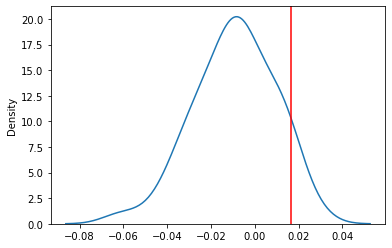

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sns.kdeplot(randomscorediffs)
plt.axvline(chronscorediff, 0, 30, color = 'r')

In [83]:
sum(randomscorediffs > chronscorediff) / len(randomscorediffs)

0.08

A difference of that size could well happen by chance, (p > .05) so we cannot be very confident that gender roles became less predictable at the end of the 20c.